3. Consider the system in Figure 1. It shows a model that predicts future outputs yn from current and past inputs xn. Figure 1(a) shows the observed signal zn which is yn – generated as xn passes through a linear system hn – corrupted by additive Gaussian noise qn. Consider the case where hn
is a “matched” Wiener filter with length L = 3 (i.e., 3-tap filter). “Matched” means that the filter coefficients are matched to the xn signal generator. Figure 1(b) shows how to apply the ideal Wiener filter wLMMSE to the input vn(u) = [xn(u), xn−1(u), xn−2(u)]T to predict future outputs yˆn
yˆn = wT LMMSE vn wLMMSE = R−1 v rvy
where the correlation matrices do not depend on the time n. Figure 1(c) shows the LMS filter which can learn to approximate the optimal filter. The LMS algorithm can also work “online”. In this mode it tracks and adaptively update the taps of hn based on an (“unmatched”) time-varying signal even when the data comes from a complex (or unknown) process.
hn xn yn qn zn xn wˆ n yˆn-rwE = 2E x(u)xt(u)wy(u)x(u) = 2(Rxwr)
rwE = 0 () Rxw = r (Wiener-Hopf equation)
wˆ n+1 = wˆ n
(⌘/2)rwE = wˆ n + ⌘(rRxwˆ n)
12rwE = rRxw = E y(u)x(u) x(u)xt(u)w ⇡ ynxn xnxt nw = (ynxtnwˆ n)xn
wˆ n+1 = wˆ n + ⌘(ynwˆ tnxn)xn

yˆn =LX1l=0 wlxnl = wt vn

w =26666664
w0
w1
.
.
.
wL
1
3
7
7
7
7
7
7
5

vn = xn
n(L1) =26666664
xn
xn
1
.
.
.
xn
L+13777777512
rwE = r
Rvnw= E
y(i)vn(u)
vn(u)vt
n(u)w = (ynvtnvˆn)xnen

⌘ zn
noisy target
xn yˆnwlmmse

(a) (b) (c)
Figure 1: (a) MMSE estimation model. (b) System using LMMSE estimator. (c) Applying
LMS with noisy targets zn.
Use the datafile lms fun.hdf5. The file includes several data arrays with keys described below. You
will first compute the 3-tap Wiener filter coefficients assuming a “matched” condition. The model is
zn(u) = yn(u) + qn(u)

zn(u) = h0xn(u) + h1xn−1(u) + h2xn−2(u) + qn(u) where xn(u) is a sequence of i.i.d. standard normal random variables with h0 = 1, h1 = 0.5, and h2 = 0.25. The noise qn(u) is also i.i.d. normal with zero mean and variance σ2q. Define the signal-to-noise ratio (SNR) as SNR = σ2xσ2q=1σ2q

(a) The hd5 datafile contains 600 sequences of length 501 samples for each of SNR = 3 dB and SNR = 10 dB. It includes an x and z array for each noise intensity: matched 10 x, matched -10 z and matched 3 x, matched 3 z. Build a filter and use the data to produce curves as in the lecture slides. Note: you may also use the included yn and vn data. You could generate vn from xn but the datafile includes the value to simplify your task.

i. Program the LMS algorithm using input (regressor) vn and “noisy target” zn. This corresponds to the example given in lecture.
ii. Plot learning curves for each SNR with η = 0.05 and η = 0.15. Learning curves are plots of the MSE – (yn − yˆn)2– w.r.t. sample number and averaged over all sequences.
iii. What is the largest value of η that does not lead to divergence of the MSE?
(b) This part uses a single realization for the input sequence x (v and output sequence y each of length 501 – e.g., , timevarying v, timevarying z. But these data came from a time- varying (but linear) filter – i.e., the coefficients above vary with n. The dataset timevarying - coefficents contains the sequences of the 3 coefficients with respect to time. Plot the coefficients vs. time n. Run the LMS algorithm using the x and z data. Find a learning rate η so that your LMS algorithm tracks the coefficient variations. Plot your coefficient estimates against the true coefficients for this case.
(c) This part uses the dataset with keys mismatched x and mismatched y. This is a set of 600 sequences of length 501 samples each. But this data comes from a non-linear (and unknown to you) process. Run the LMS algorithm over all 600 sequences. Find several good values for η and plot the average learning curves. Note: you only have access to the noisy yn in this part.
Compute Rˆv and rˆvy and the corresponding LLSE using the entire set. Is this value lower than the LMS learning curve after convergence?

In [ ]:
# Importing the required liraries.
import h5py    
import numpy as np    
import matplotlib.pyplot as plt

h5f = h5py.File("lms_fun_v3.hdf5",'r+') # Porting the dataset to Google Co-laboratory. 

# Signal-to-Noise Ratio 3dB inputs.
inputx_3db = h5f["matched_3_x"][:]
inputv_3db = h5f["matched_3_v"][:]
# Signal-to-Noise Ratio 3dB outputs.
outputy_3db = h5f["matched_3_y"][:] # Before noise.
outputz_3db = h5f["matched_3_z"][:] # After noise.

# Signal-to-Noise Ratio 10dB inputs.
inputx_10db = h5f["matched_10_x"][:]
inputv_10db = h5f["matched_10_v"][:]
# Signal-to-Noise Ratio 10dB outputs.
outputy_10db = h5f["matched_10_y"][:] # Before noise.
outputz_10db = h5f["matched_10_z"][:] # Before noise.

# Time varying inputs.
inputx_time = h5f["timevarying_x"][:]
inputv_time = h5f["timevarying_v"][:]
# Time varying outputs.
outputy_time = h5f["timevarying_y"][:]
outputz_time = h5f["timevarying_z"][:]
time_coefficient = h5f["timevarying_coefficents"][:]

# Mismatched inputs.
mismatch_inputx = h5f["mismatched_x"][:]
mismatch_inputv = h5f["mismatched_v"][:]
# Mismatched outputs.
mismatch_outputy = h5f["mismatched_y"][:]


# Parametrs:
# ip: Input sequence
# op: Output sequence
# lr: Learning rate
# run type: It defines if it is "S: single run" or "A: Average over every sequence"
# ques: It checks which question to plot the corresponding graphs
# Plot titles

def lms(input, output, e, runtime):
    loss = []
    iter_loss = []
    weights = []
    weights_1 = []
    weights_2 = []
    weights_3 = []
    
    for i in range(len(input)):
        iter_loss = []
        w = np.array([0,0,0])
        weights = []
        for j in range(len(input)):
                output_prediction = np.inner(w, input[i][j])
                err = output[i][j] - output_prediction
                iter_loss.append(err**2)
                w = w + (e * err * input[i][j])
                output_prediction = np.inner(w, input[j])
                err = output[j] - output_prediction
                iter_loss.append(err**2) 
                w = w + (e * err * input[j])

        weights.append(w)
        weights_arr = np.array(weights)

        weights_1.append((weights_arr[:, 0]))
        weights_2.append((weights_arr[:, 1]))
        weights_3.append((weights_arr[:, 2]))
        loss.append(iter_loss)

    lossarray = (np.array(loss)).T
    mse = np.zeros(501)
    weights_1 = (np.array(weights_1)).T
    weights_2 = (np.array(weights_2)).T
    weights_3 = (np.array(weights_3)).T
    coefficient_1 = np.zeros(501)
    coefficient_2 = np.zeros(501)
    coefficient_3 = np.zeros(501)
    
    for i in range(0, 501):
        # Calculating the Mean Square Error.
        mse[i] = 10 * np.log10(np.mean(lossarray[i]))
        # Computing the mean of each weight vector.
        coefficient_1[i] = np.mean(weights_1[i])
        coefficient_2[i] = np.mean(weights_2[i])
        coefficient_3[i] = np.mean(weights_3[i])
        
    x_r = range(0, 501)

    plt.plot(x_r, mse, label = "MSE for LMS")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("MSE in dB")
    plt.show()
    plt.plot(x_r, time_coefficient[:,0], label = "Actual Weight-0")
    plt.plot(x_r, time_coefficient[:,1], label = "Actual Weight-1")
    plt.plot(x_r, time_coefficient[:,2], label = "Actual Weight-2")
    plt.legend()   
    plt.plot(x_r, coefficient_1, label = "Weight-0 Estimates")
    plt.plot(x_r, coefficient_2, label = "Weight-1 Estimates")
    plt.plot(x_r, coefficient_3, label = "Weight-2 Estimates")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("Weight Values")
    plt.show()

def lms1(input, output, e, runtime):
    loss = []
    iter_loss = []
    weights = []
    weights_1 = []
    weights_2 = []
    weights_3 = []
    
    for i in range(len(input)):
        iter_loss = []
        w = np.array([0,0,0])
        weights = []
        for j in range(len(input)):
                output_prediction = np.inner(w, input[i][j])
                err = output[i][j] - output_prediction
                iter_loss.append(err**2)
                w = w + (e * err * input[i][j])
                output_prediction = np.inner(w, input[j])
                err = output[j] - output_prediction
                iter_loss.append(err**2) 
                w = w + (e * err * input[j])

        weights.append(w)
        weights_arr = np.array(weights)

        weights_1.append((weights_arr[:, 0]))
        weights_2.append((weights_arr[:, 1]))
        weights_3.append((weights_arr[:, 2]))
        loss.append(iter_loss)

    lossarray = (np.array(loss)).T
    mse = np.zeros(501)
    weights_1 = (np.array(weights_1)).T
    weights_2 = (np.array(weights_2)).T
    weights_3 = (np.array(weights_3)).T
    coefficient_1 = np.zeros(501)
    coefficient_2 = np.zeros(501)
    coefficient_3 = np.zeros(501)
    
    for i in range(0, 501):
        # Calculating the Mean Square Error.
        mse[i] = 10 * np.log10(np.mean(lossarray[i]))
        # Computing the mean of each weight vector.
        coefficient_1[i] = np.mean(weights_1[i])
        coefficient_2[i] = np.mean(weights_2[i])
        coefficient_3[i] = np.mean(weights_3[i])
        
    x_r = range(0, 501)

    plt.plot(x_r, mse, label = "MSE for LMS")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("MSE in dB")
    plt.show()
    plt.plot(x_r, time_coefficient[:,0], label = "Actual Weight-0")
    plt.plot(x_r, time_coefficient[:,1], label = "Actual Weight-1")
    plt.plot(x_r, time_coefficient[:,2], label = "Actual Weight-2")
    plt.legend()   
    plt.plot(x_r, coefficient_1, label = "Weight-0 Estimates")
    plt.plot(x_r, coefficient_2, label = "Weight-1 Estimates")
    plt.plot(x_r, coefficient_3, label = "Weight-2 Estimates")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("Weight Values")
    plt.show()

def lms2(input, output, e, runtime):
    loss = []
    iter_loss = []
    weights = []
    weights_1 = []
    weights_2 = []
    weights_3 = []
    
    for i in range(len(input)):
        iter_loss = []
        w = np.array([0,0,0])
        weights = []
        for j in range(len(input)):
                output_prediction = np.inner(w, input[i][j])
                err = output[i][j] - output_prediction
                iter_loss.append(err**2)
                w = w + (e * err * input[i][j])
                output_prediction = np.inner(w, input[j])
                err = output[j] - output_prediction
                iter_loss.append(err**2) 
                w = w + (e * err * input[j])

        weights.append(w)
        weights_arr = np.array(weights)

        weights_1.append((weights_arr[:, 0]))
        weights_2.append((weights_arr[:, 1]))
        weights_3.append((weights_arr[:, 2]))
        loss.append(iter_loss)

    lossarray = (np.array(loss)).T
    mse = np.zeros(501)
    weights_1 = (np.array(weights_1)).T
    weights_2 = (np.array(weights_2)).T
    weights_3 = (np.array(weights_3)).T
    coefficient_1 = np.zeros(501)
    coefficient_2 = np.zeros(501)
    coefficient_3 = np.zeros(501)
    
    for i in range(0, 501):
        # Calculating the Mean Square Error.
        mse[i] = 10 * np.log10(np.mean(lossarray[i]))
        # Computing the mean of each weight vector.
        coefficient_1[i] = np.mean(weights_1[i])
        coefficient_2[i] = np.mean(weights_2[i])
        coefficient_3[i] = np.mean(weights_3[i])
        
    x_r = range(0, 501)

    plt.plot(x_r, mse, label = "MSE for LMS")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("MSE in dB")
    plt.show()
    plt.plot(x_r, time_coefficient[:,0], label = "Actual Weight-0")
    plt.plot(x_r, time_coefficient[:,1], label = "Actual Weight-1")
    plt.plot(x_r, time_coefficient[:,2], label = "Actual Weight-2")
    plt.legend()   
    plt.plot(x_r, coefficient_1, label = "Weight-0 Estimates")
    plt.plot(x_r, coefficient_2, label = "Weight-1 Estimates")
    plt.plot(x_r, coefficient_3, label = "Weight-2 Estimates")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("Weight Values")
    plt.show()

(a) The hd5 datafile contains 600 sequences of length 501 samples for each of SNR = 3 dB and SNR = 10 dB. It includes an x and z array for each noise intensity: matched 10 x, matched - 10 z and matched 3 x, matched 3 z. Build a filter and use the data to produce curves as in the lecture slides. Note: you may also use the included yn and vn data. You could generate vn from xn but the datafile includes the value to simplify your task.
ii. Plot learning curves for each SNR with η = 0.05 and η = 0.15. Learning curves are plots of the MSE – (yn − yˆn)2– w.r.t. sample number and averaged over all sequences.

Plots for n = 0.05, SNR = 3 dB


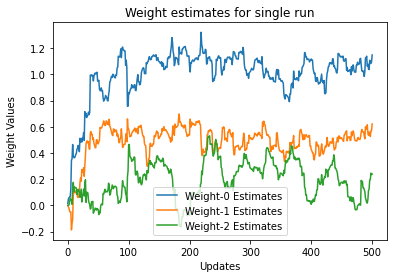

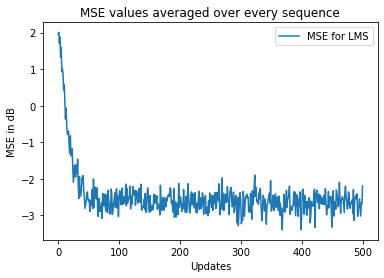

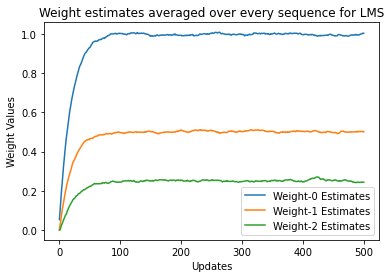

In [ ]:
print("Plots for n = 0.05, SNR = 3 dB")
lms(inputv_3db, outputz_3db, 0.05, 1)
lms(inputv_3db, outputz_3db, 0.05, 600)

Plots for n = 0.15, SNR = 3 dB


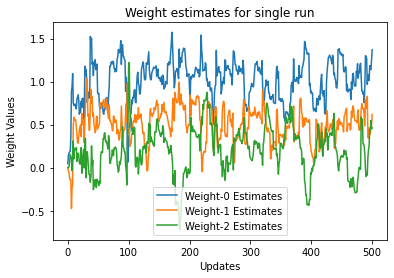

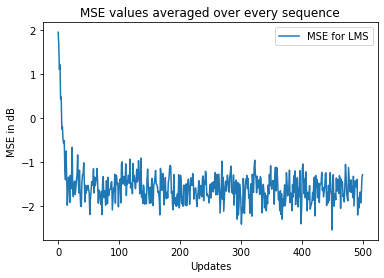

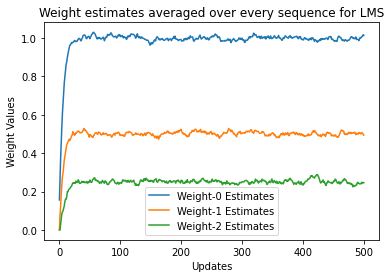

In [ ]:
print("Plots for n = 0.15, SNR = 3 dB")
lms(inputv_3db, outputz_3db, 0.15, 1)
lms(inputv_3db, outputz_3db, 0.15, 600)

Plots for n = 0.2, SNR = 3 dB


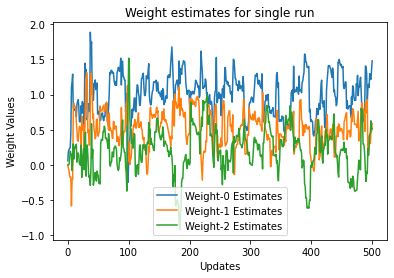

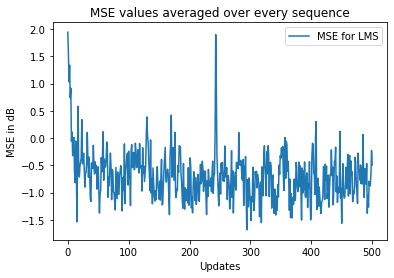

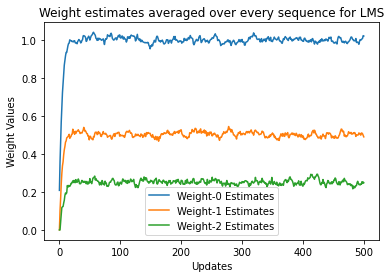

In [ ]:
print("Plots for n = 0.2, SNR = 3 dB")
lms(inputv_3db, outputz_3db, 0.2, 1)
lms(inputv_3db, outputz_3db, 0.2, 600)

Plots for n = 0.25, SNR = 3 dB


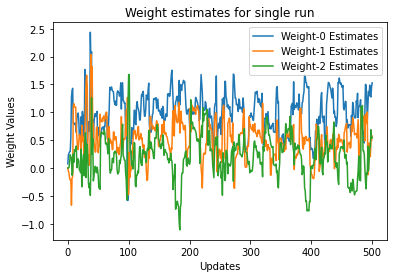

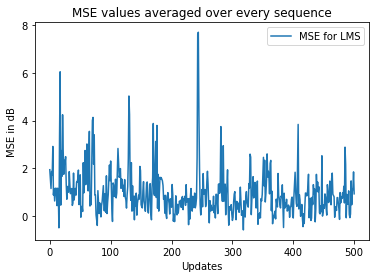

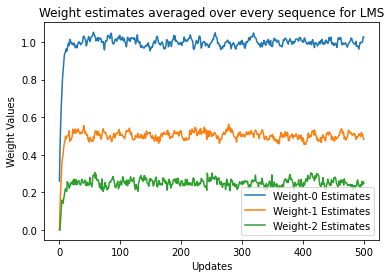

In [ ]:
print("Plots for n = 0.25, SNR = 3 dB")
lms(inputv_3db, outputz_3db, 0.25, 1)
lms(inputv_3db, outputz_3db, 0.25, 600)

It is evident from the above graphs that the Mean Squared Error curve starts to diverge when n > 0.2. So, the largest value of n for SNR = 3 dB which does not lead to divergence of Mean Squared Error curve is 0.2.

Plots for n = 0.05, SNR = 10 dB


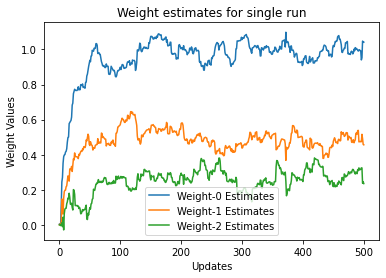

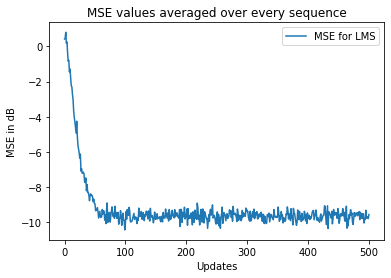

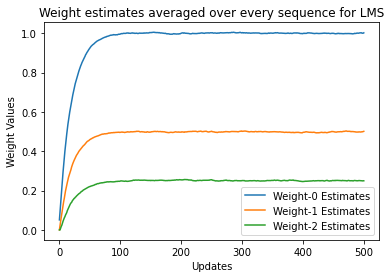

In [ ]:
print("Plots for n = 0.05, SNR = 10 dB")
lms(inputv_10db, outputz_10db, 0.05, 1)
lms(inputv_10db, outputz_10db, 0.05, 600)

Plots for n = 0.15, SNR = 10 dB


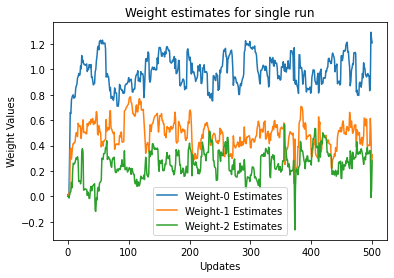

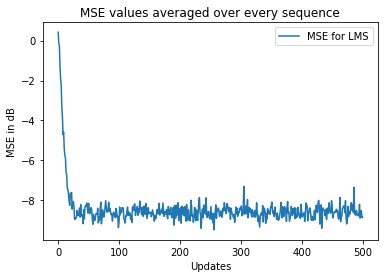

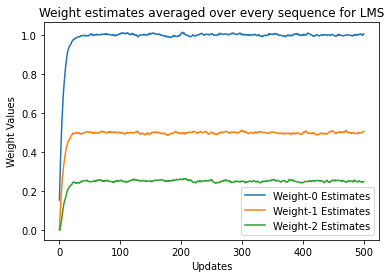

In [ ]:
print("Plots for n = 0.15, SNR = 10 dB")
lms(inputv_10db, outputz_10db, 0.15, 1)
lms(inputv_10db, outputz_10db, 0.15, 600)

Plots for n = 0.2, SNR = 10 dB


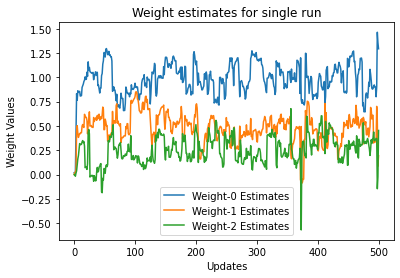

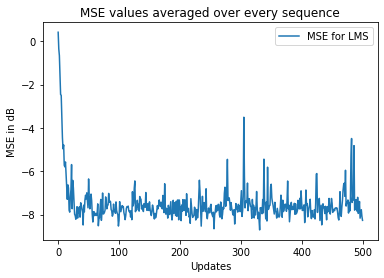

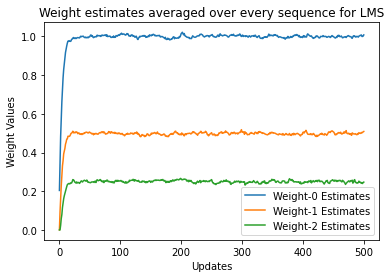

In [ ]:
print("Plots for n = 0.2, SNR = 10 dB")
lms(inputv_10db, outputz_10db, 0.2, 1)
lms(inputv_10db, outputz_10db, 0.2, 600)

Plots for n = 0.25, SNR = 10 dB


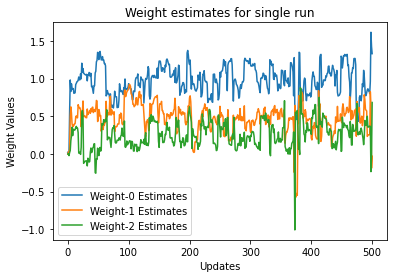

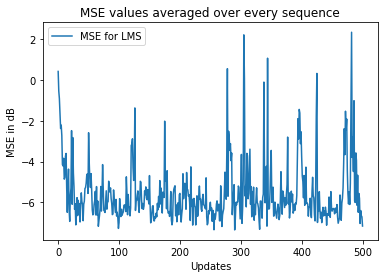

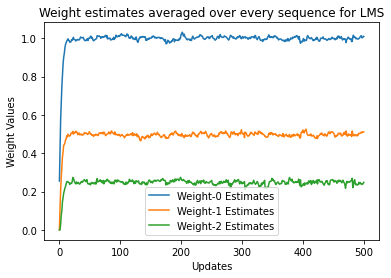

In [ ]:
print("Plots for n = 0.25, SNR = 10 dB")
lms(inputv_10db, outputz_10db, 0.25, 1)
lms(inputv_10db, outputz_10db, 0.25, 600)

It is evident from the above graphs that the Mean Squared Error curve starts to diverge when n > 0.25. So, the largest value of n for SNR = 10 dB which does not lead to divergence of Mean Squared Error curve is 0.25.

(b) This part uses a single realization for the input sequence x (v and output sequence y each of length 501 – e.g., , timevarying v, timevarying z. But these data came from a time-varying (but linear) filter – i.e., the coefficients above vary with n. The dataset timevarying -coefficents contains the sequences of the 3 coefficients with respect to time.
Plot the coefficients vs. time n. Run the LMS algorithm using the x and z data. Find a learning rate η so that your LMS algorithm tracks the coefficient variations. Plot your coefficient estimates against the true coefficients for this case.

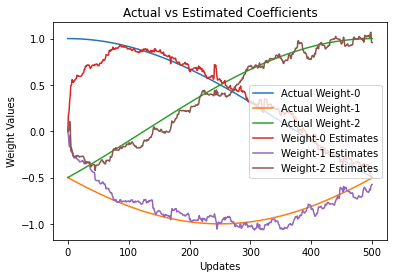

In [ ]:
lms1(inputv_time, outputz_time, 0.05, wt_s_plt = "Actual vs Estimated Coefficients")

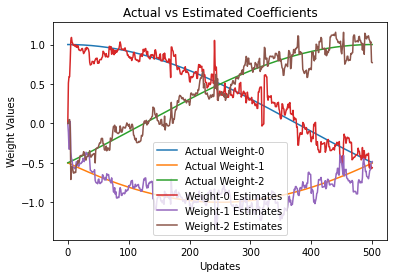

In [ ]:
lms1(inputv_time, outputz_time, 0.15, wt_s_plt = "Actual vs Estimated Coefficients")

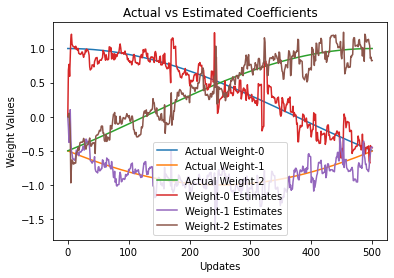

In [ ]:
lms1(inputv_time, outputz_time, 0.20, wt_s_plt = "Actual vs Estimated Coefficients")

It can be concluded from the above graphs that the LMS algorithm tracks the coefficient variations best for the value of n = 0.15.


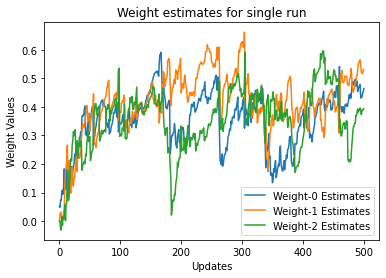

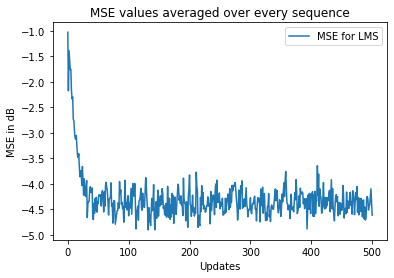

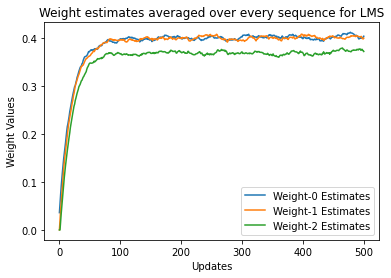

In [ ]:
lms2(mismatch_inputv, mismatch_outputy, 0.05)
lms2(mismatch_inputv, mismatch_outputy, 0.05)

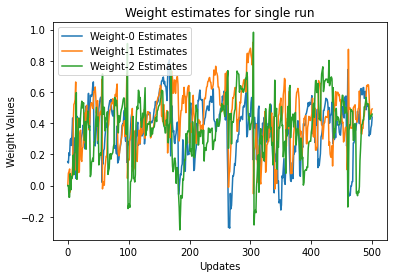

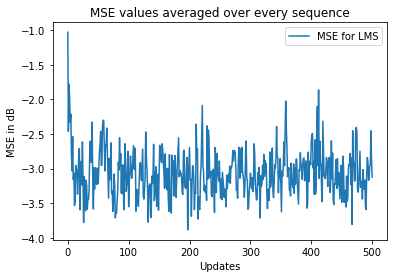

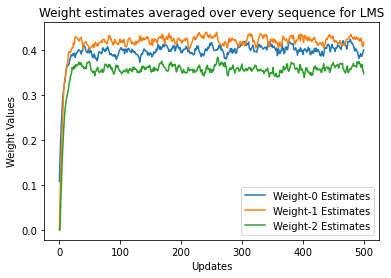

In [ ]:
lms2(mismatch_inputv, mismatch_outputy, 0.15)
lms2(mismatch_inputv, mismatch_outputy, 0.15)

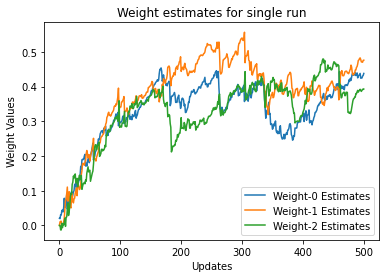

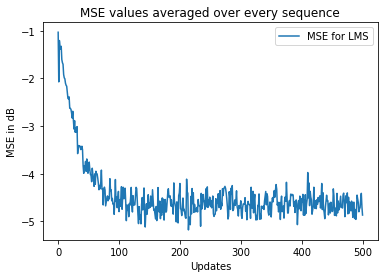

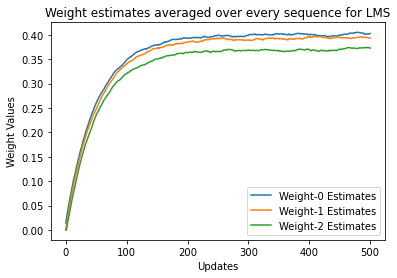

In [ ]:
lms2(mismatch_inputv, mismatch_outputy, 0.02)
lms2(mismatch_inputv, mismatch_outputy, 0.02)

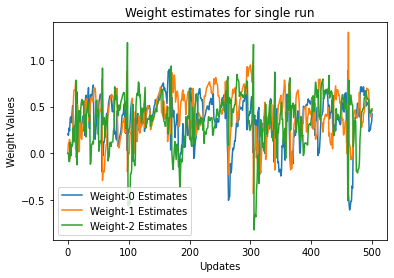

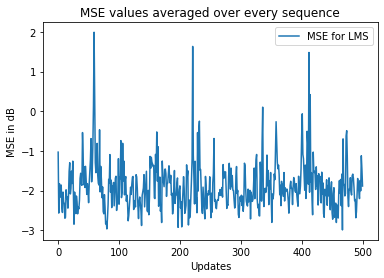

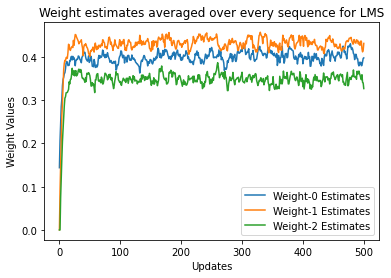

In [ ]:
lms2(mismatch_inputv, mismatch_outputy, 0.2)
lms2(mismatch_inputv, mismatch_outputy, 0.2)

It is inferred from the above graphs that for the mismatched dataset the LMS algorithm's accuracy is better for the value of n upto 0.15.

In [ ]:
def llse(input, output):
    auto_corr = np.zeros([600, 1, 3, 3])
    for i in range(600):
        input_T = input[i].T
        auto_corr[i] = np.matmul(input_T, input[i])

    Rv = np.mean(auto_corr, axis = 0)
    RV_inverse = np.linalg.inv(Rv)
    cov = np.zeros([600,1,3,1])

    for i in range(600):
        input_T = input[i].T
        cov[i] = np.matmul(input_T, output[i].reshape([501,1]))
    
    Rvy = np.mean(cov, axis = 0)

    LLSE_wt = (np.matmul(RV_inverse, Rvy)).squeeze()           
    n1 = len(input)
    n2 = len(input[0])
    loss = []
    
    for i in range(600):
        iter_loss = []
        for j in range(501):
            output_prediction = np.inner(LLSE_wt, input[i][j])
            err = output[i][j] - output_prediction
            iter_loss.append(err**2)
        loss.append(iter_loss)

    loss_array = (np.array(loss)).T
    mse = np.zeros(501)

    for i in range(0,501):
        mse[i] = 10 * np.log10(np.mean(loss_array[i]))

    plt.plot(range(501), mse, label = "MSE for LLSE")
    plt.legend()
    plt.xlabel("Updates")
    plt.ylabel("MSE in dB")
    wt_plt_title = "Weight estimates averaged over every sequence for LLSE"
    lms(input, output, 0.05, mse_plt = "LLSE vs LMS", wt_a_plt = wt_plt_title)

(c) This part uses the dataset with keys mismatched x and mismatched y. This is a set of 600 sequences of length 501 samples each. But this data comes from a non-linear (and unknown to you) process. Run the LMS algorithm over all 600 sequences. Find several good values for η and plot the average learning curves. Note: you only have access to the noisy yn in this part.
Compute Rˆv and rˆvy and the corresponding LLSE using the entire set. Is this value lower than the LMS learning curve after convergence?

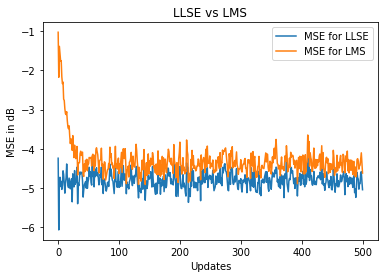

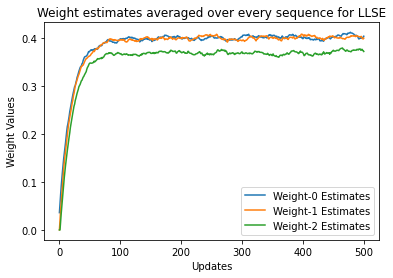

In [ ]:
llse(mismatch_inputv, mismatch_outputy)

The LLSE algoritham has lower Mean Square Error compared to the LMS learning curve (even after convergence).